# Bitcoin Linear Regression: EDA
2 February 2018

This notebook explores the data in detail, acting as supplement to the LR analysis.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import time
import sys
import re
import datetime

In [2]:
# Helper functions
def str_to_int(str):
    str2 = int(str.replace('$','').replace(',',''))
    return str2

def to_currency(int):
    return '{:,}'.format(int)

# def thousands(int):
#     divided = int // 1000
#     return to_currency(divided)

# def y_fmt(x, y):
#     return '{:2.2e}'.format(x).replace('e', 'x10^')

In [3]:
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['BTCPrice','ETHPrice','BTCVol','TxFees','CostperTxn','NoTxns','AvgBlkSz','UniqueAddresses','HashRate','Crypto Market Cap','Nasdaq','Gold','Interest']]
df_all = df
df_hist = df
df.head()

,BTCPrice,ETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,Crypto Market Cap,Nasdaq,Gold,Interest
2016-07-13,656.669626,10.55,871225.091442,34693.70,5.69,219034.0,0.77,379937.0,1516960.89,1.225459e+10,5005.73,227.19,3.0
2016-07-14,656.132060,10.49,872834.409470,35233.50,5.06,218093.0,0.81,367252.0,1379055.35,1.225459e+10,5034.06,226.88,3.0
2016-07-15,663.841255,11.50,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,1.225459e+10,5029.59,224.00,3.0
2016-07-17,663.841255,11.50,756558.628070,38613.99,5.49,220655.0,0.79,367953.0,1506352.77,1.288271e+10,5029.59,224.00,2.0
2016-07-18,680.149570,11.35,752528.346010,32557.41,7.59,171013.0,0.70,330330.0,1580609.59,1.288271e+10,5055.78,224.43,2.0


In [4]:
df_all.corr().sort_values('BTCPrice')

,BTCPrice,ETHPrice,BTCVol,TxFees,CostperTxn,NoTxns,AvgBlkSz,UniqueAddresses,HashRate,Crypto Market Cap,Nasdaq,Gold,Interest
BTCVol,-0.227518,-0.268913,1.000000,-0.159270,-0.239178,0.025847,-0.144598,-0.149801,-0.293037,-0.217108,-0.400853,-0.225275,-0.196278
Gold,-0.183660,-0.140151,-0.225275,-0.117486,-0.151089,-0.379043,-0.379336,-0.382417,-0.214437,-0.119496,-0.347817,1.000000,-0.208530
NoTxns,0.494046,0.288925,0.025847,0.458144,0.347951,1.000000,0.620083,0.866034,0.389096,0.359744,0.390054,-0.379043,0.545179
AvgBlkSz,0.567791,0.530573,-0.144598,0.485593,0.519419,0.620083,1.000000,0.684447,0.546627,0.531367,0.632095,-0.379336,0.539945
UniqueAddresses,0.807229,0.647042,-0.149801,0.732753,0.696859,0.866034,0.684447,1.000000,0.715293,0.696561,0.714712,-0.382417,0.805566
Nasdaq,0.814380,0.858675,-0.400853,0.620272,0.829572,0.390054,0.632095,0.714712,0.923766,0.805742,1.000000,-0.347817,0.736147
TxFees,0.871254,0.777047,-0.159270,1.000000,0.874376,0.458144,0.485593,0.732753,0.709614,0.853392,0.620272,-0.117486,0.803290
ETHPrice,0.882184,1.000000,-0.268913,0.777047,0.931794,0.288925,0.530573,0.647042,0.935348,0.969806,0.858675,-0.140151,0.756726
HashRate,0.905141,0.935348,-0.293037,0.709614,0.928645,0.389096,0.546627,0.715293,1.000000,0.920718,0.923766,-0.214437,0.798561
Crypto Market Cap,0.925850,0.969806,-0.217108,0.853392,0.956028,0.359744,0.531367,0.696561,0.920718,1.000000,0.805742,-0.119496,0.810020


## Presentation Exhibits

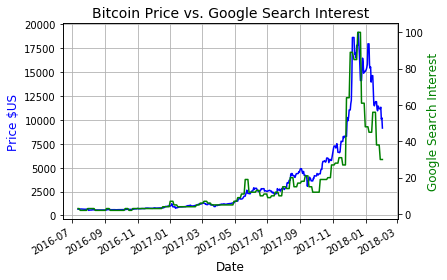

None


In [5]:
# BTC Price vs Google Search Interest
# from matplotlib.ticker import FormatStrFormatter
# import matplotlib.ticker as tick


df_all = df
y1 = pd.Series(df_all['BTCPrice'])
y2 = pd.Series(df_all['Interest'])
x = pd.Series(df_all.index.values)

fig, ax = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x,y1,'b')
ax2.plot(x,y2,'g')
ax.set_ylabel("Price $US",color='b',fontsize=12)
ax2.set_ylabel("Google Search Interest",color='g',fontsize=12)
ax.grid(True)
plt.title("Bitcoin Price vs. Google Search Interest", fontsize=14)
ax.set_xlabel('Date', fontsize=12)
fig.autofmt_xdate()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

plt.savefig('charts/googlesearchinterest.png')
print(plt.show())

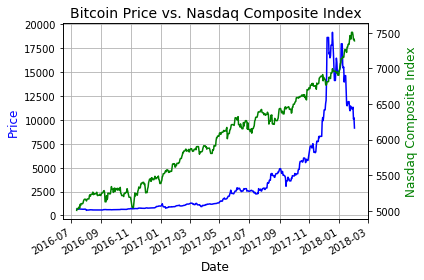

None


In [6]:
# BTC Price vs Nasdaq
y2 = pd.Series(df_all['Nasdaq'])

fig, ax = plt.subplots()

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=12,color='blue')
ax2.set_ylabel("Nasdaq Composite Index",fontsize=12,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Nasdaq Composite Index", fontsize=14,color='black')
ax.set_xlabel('Date', fontsize=12, color='black')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('charts/nasdaq.png')
print(plt.show())

## Supplemental Information

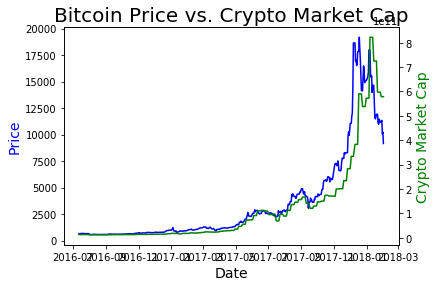

None


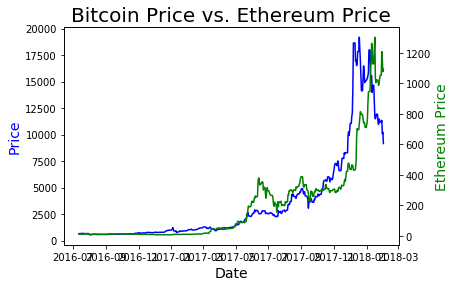

None


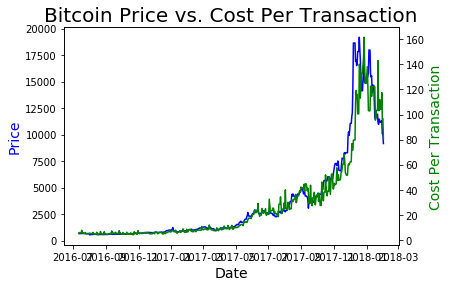

None


In [7]:
# BTC Price vs Crypto Market Cap
y2 = pd.Series(df_all['Crypto Market Cap'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Crypto Market Cap",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Crypto Market Cap", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/cryptomarketcap.png')
print(plt.show())

# BTC Price vs ETH Price
y2 = pd.Series(df_all['ETHPrice'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Ethereum Price",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Ethereum Price", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/ethprice.png')
print(plt.show())

# BTC Price vs ETH Price
y2 = pd.Series(df_all['CostperTxn'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Cost Per Transaction",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Price vs. Cost Per Transaction", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/costpertxn.png')
print(plt.show())

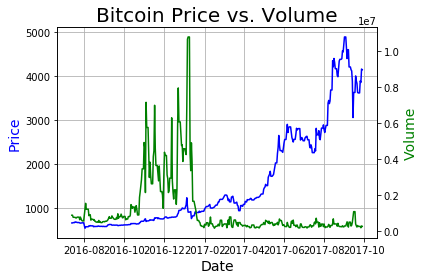

None


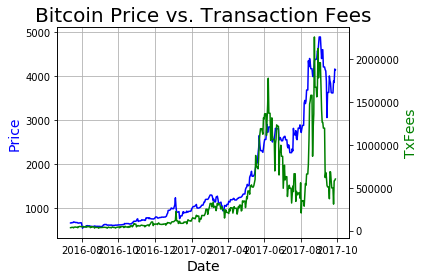

None


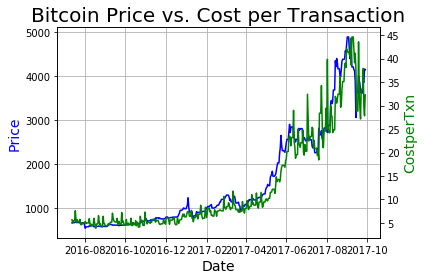

None


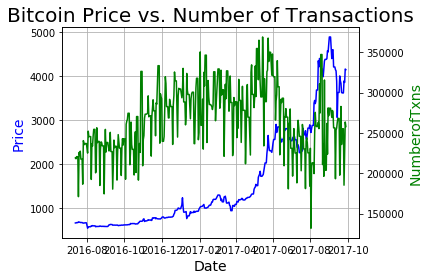

None


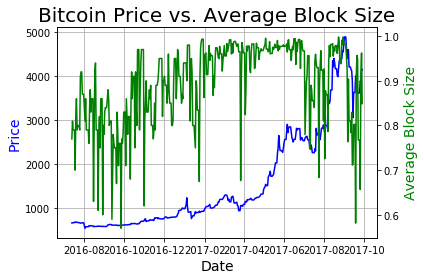

None


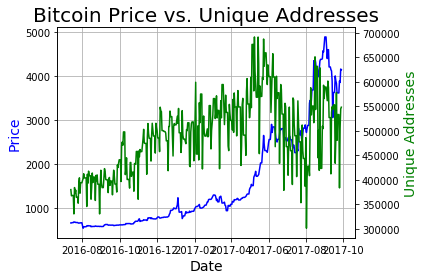

None


In [8]:
# BTC Price vs Volume
df_all = df_all[:365]

y1 = pd.Series(df_all['BTCPrice'])
y2 = pd.Series(df_all['BTCVol'])
x = pd.Series(df_all.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Volume",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Volume", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig1.png')
print(plt.show())

# BTC Price vs Transaction Fees
y2 = pd.Series(df_all['TxFees'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("TxFees",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Transaction Fees", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig2.png')
print(plt.show())

# BTC Price vs Cost per Transaction
y2 = pd.Series(df_all['CostperTxn'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("CostperTxn",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Cost per Transaction", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig3.png')
print(plt.show())

# BTC Price vs Number of Transactions
y2 = pd.Series(df_all['NoTxns'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("NumberofTxns",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Number of Transactions", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig4.png')
print(plt.show())


# BTC Price vs Block Size
y2 = pd.Series(df_all['AvgBlkSz'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Average Block Size",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Average Block Size", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig6.png')
print(plt.show())

# BTC Price vs Unique Addresses
y2 = pd.Series(df_all['UniqueAddresses'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Unique Addresses",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Unique Addresses", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig7.png')
print(plt.show())

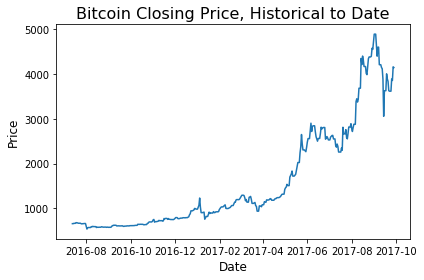

None


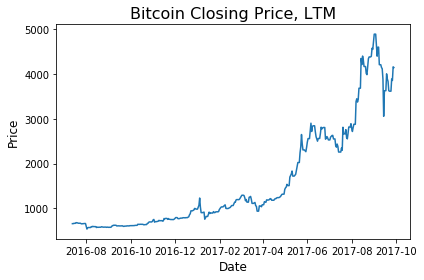

None


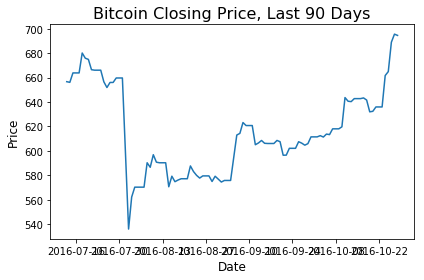

None


In [9]:
df = df_all
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCPriceQuandl.png')
print(plt.show())

df = df[:365]
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCPriceQuandl.png')
print(plt.show())

df = df[:90]
y = pd.Series(df['BTCPrice'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCPriceQuandl.png')
print(plt.show())

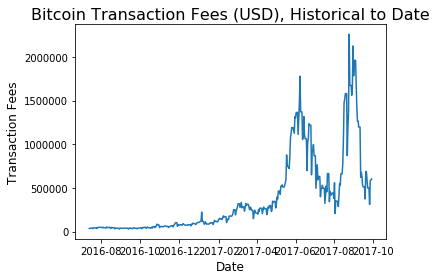

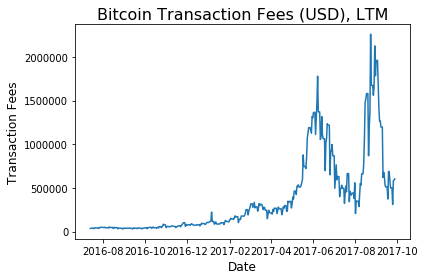

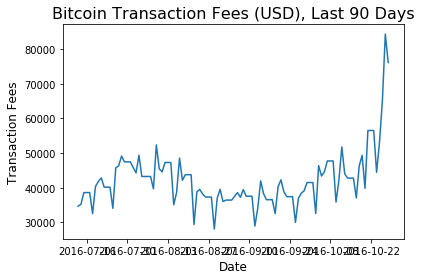

In [10]:
df = df_all
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnFeesQuandl.png')
plt.show()

df = df[:365]
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCTxnFeesQuandl.png')
plt.show()

df = df[:90]
y = pd.Series(df['TxFees'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCTxnFeesQuandl.png')
plt.show()

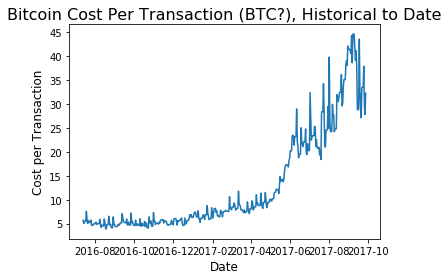

In [11]:
df = df_all
y = pd.Series(df['CostperTxn'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Cost Per Transaction (BTC?), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cost per Transaction', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCCostperTxnQuandl.png')
plt.show()

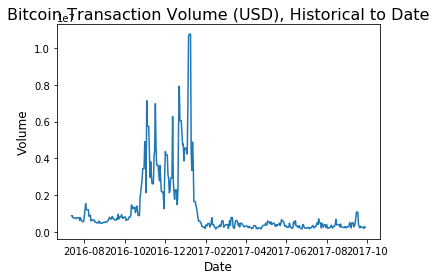

In [12]:
df = df_all
y = pd.Series(df['BTCVol'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Transaction Volume (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnVolQuandl.png')
plt.show()

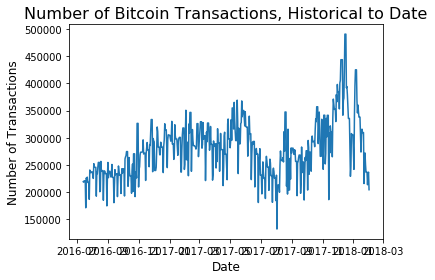

In [13]:
df = df_hist
y = pd.Series(df['NoTxns'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Number of Bitcoin Transactions, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnAmtQuandl.png')
plt.show()

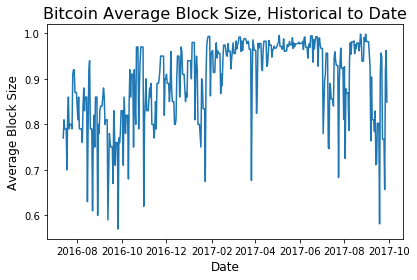

In [14]:
df = df_all
y = pd.Series(df['AvgBlkSz'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Average Block Size, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Block Size', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCAvgBlockSizeQuandl.png')
plt.show()

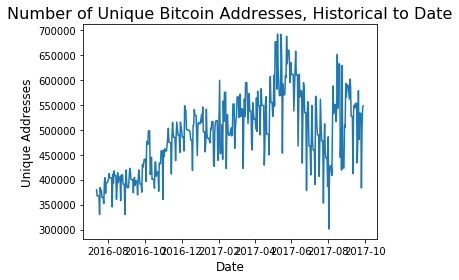

In [15]:
# Quandl: Unique BTC Addresses
df = df_all
y = pd.Series(df['UniqueAddresses'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Number of Unique Bitcoin Addresses, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unique Addresses', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCNoAddressesQuandl.png')
plt.show()

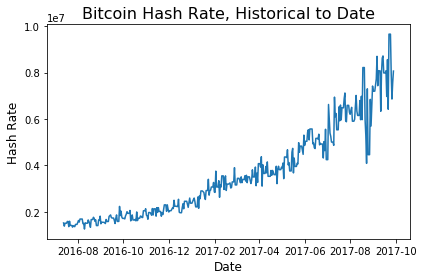

In [16]:
# Quandl: BTC Hash Rate
df = df_all
y = pd.Series(df['HashRate'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Hash Rate, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hash Rate', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCHashRateQuandl.png')
plt.show()

## Twitter Sentiment Analysis Results
This is one week of real time data.  Too much noise for evaluation at this time, but plan to aggregate this into daily
averages and incorporate over a longer time period in a future analysis.


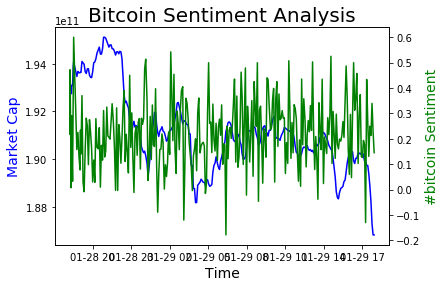

None


In [17]:
btcsa = pd.read_pickle('data/benson_btcsentiment_dfs.pkl')

y1 = pd.Series(btcsa['BTC']).apply(str_to_int)
y2 = pd.Series(btcsa['Bitcoin_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#bitcoin Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Bitcoin Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.yticks(np.arange(0,max(y1),1e11))
plt.savefig('charts/btcsa.png')
print(plt.show())

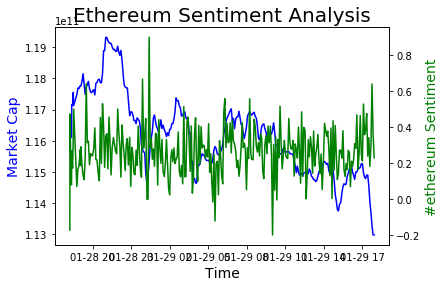

None


In [18]:
y1 = pd.Series(btcsa['ETH']).apply(str_to_int)
y2 = pd.Series(btcsa['Ethereum_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#ethereum Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Ethereum Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/ethsa.png')
print(plt.show())

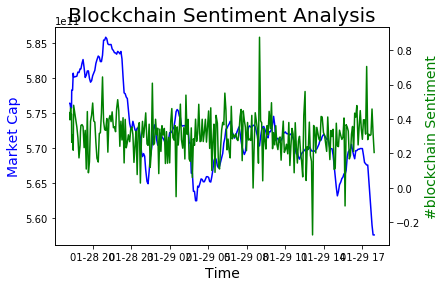

None


In [19]:
y1 = pd.Series(btcsa['Crypto Market Cap']).apply(str_to_int)
y2 = pd.Series(btcsa['Blockchain_S'])
x = pd.Series(btcsa.index.values)

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Market Cap",fontsize=14,color='blue')
ax2.set_ylabel("#blockchain Sentiment",fontsize=14,color='green')
# ax.grid(True)
plt.title("Blockchain Sentiment Analysis", fontsize=20,color='black')
ax.set_xlabel('Time', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/blksa.png')
print(plt.show())

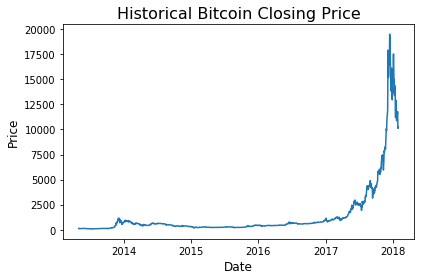

None


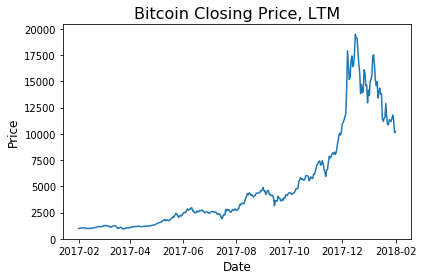

None


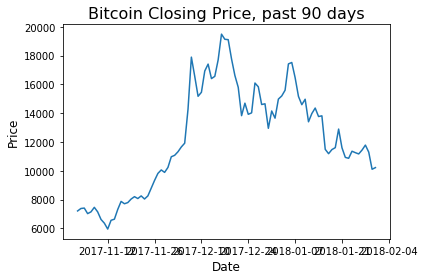

In [20]:
df = pd.read_pickle('data/benson_btcsentiment_dfts.pkl')

y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Historical Bitcoin Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalBitcoinPrice.png')
print(plt.show())

# Bitcoin Closing Price, past year
df = df[:365]
y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
print(plt.show())

# Bitcoin past 90 days
df = df[:90]
y = pd.Series(df['Close'])
x = pd.Series(df.index.values)

plt.plot(x,y)
plt.title("Bitcoin Closing Price, past 90 days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
plt.show()

In [21]:
# Coinmarketcap scraping: Ethereum
df_eth = pd.read_pickle('data/benson_btcsentiment_dftseth.pkl')
df_eth.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2018-01-31,1071.09,1128.66,1034.50,1118.31,3757560000,104231000000
2018-01-30,1184.13,1184.63,1058.97,1071.13,4107860000,115207000000
2018-01-29,1246.70,1256.70,1169.08,1182.36,3715080000,121269000000
2018-01-28,1111.78,1257.77,1111.78,1246.01,5372330000,108122000000
2018-01-27,1055.75,1121.98,1042.12,1107.07,3002870000,102651000000


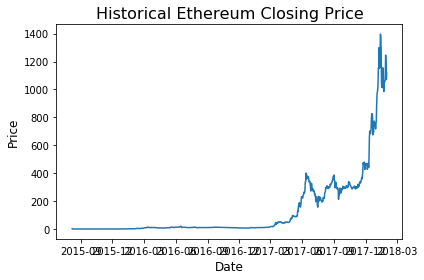

None


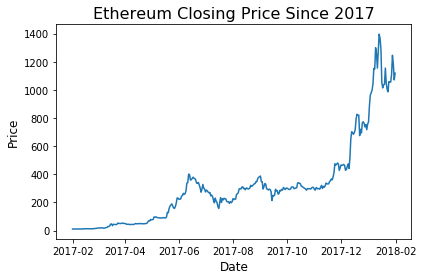

None


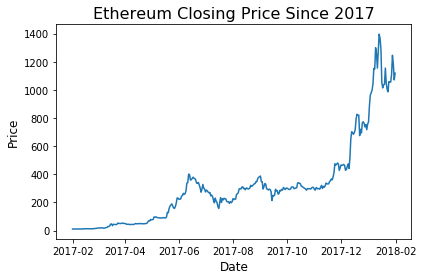

In [22]:
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("Historical Ethereum Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalEthereumPrice.png')
print(plt.show())

# LTM
df_eth = df_eth[:365]
# print(df.tail())
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/EthereumPrice2017.png')
print(plt.show())

# Last 90 days
df_eth = df_eth[:365]
# print(df.tail())
y = pd.Series(df_eth['Close'])
x = pd.Series(df_eth.index.values)

plt.plot(x,y)
plt.title("Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/EthereumPrice2017a.png')
plt.show()